# CFD Coursework 2: Square Duct

Read DNS data from https://www.cttc.upc.edu/downloads/DuctFlow/

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Global Settings

In [3]:
figsize = (10, 8)
Re_numbers = [300] # one or more from [300, 600, 900, 1200]

## YZ Sections

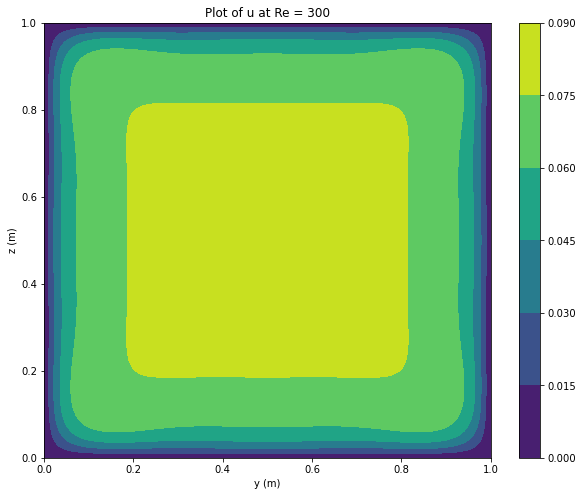

In [4]:
def read_yz_sections(fpath):
    df = pd.read_csv(fpath, delimiter=' ').reset_index()
    df.columns = ['y'] + list(df.iloc[0][1:])
    df = df.drop([0, 1], axis=0).reset_index(drop=True).astype('float')
    return df

for Re in Re_numbers:
    section_data_fpath = f'DuctFlow/YZsections/Re{Re}/DuctFlow_Re{Re}_YZ.dat'
    u_tau = Re * 1.48e-5
    section_data = read_yz_sections(section_data_fpath)
    plt.figure(figsize=figsize)
    plt.tricontourf(section_data['y'], section_data['z'], section_data["<u>"]*u_tau) 
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    plt.title(f"Plot of u at Re = {Re}")
    plt.colorbar()

## StarCCM Simulation

This was done with Re = 300 and the Elliptical Blending Reynolds Stress turbulence model.

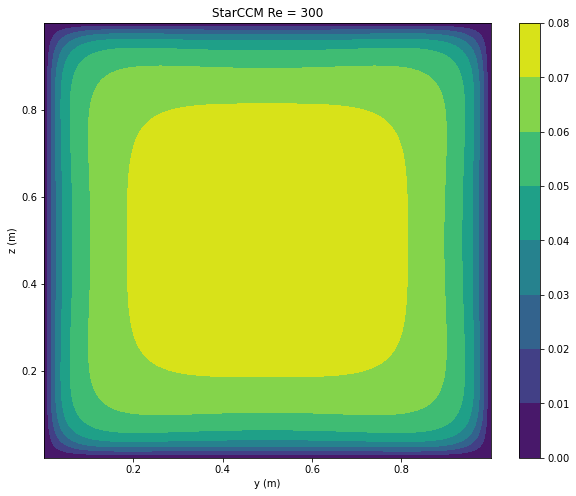

In [5]:
starccm_data = pd.read_csv('data.csv')

plt.figure(figsize=figsize)
plt.tricontourf(starccm_data['Y (m)'], starccm_data['Z (m)'], starccm_data['Velocity[i] (m/s)']) 
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.title('StarCCM Re = 300')
plt.colorbar()

# Downsampling

In [6]:
down_sampled = []

for i in range(len(section_data)):
    row = section_data.iloc[i]
    y = row['y']
    z = row['z']
    
    # Downsample by finding 'nearest points' (Euclidean distance)
    distances = (starccm_data['Y (m)'] - y)**2 + (starccm_data['Z (m)'] - z)**2
    min_idx = distances.argmin()
    down_sampled.append(starccm_data.iloc[min_idx])
    
down_sampled = pd.concat(down_sampled, axis=1).T.reset_index().drop('index', axis=1)

## Errors

In [7]:
mse = np.mean(np.square(down_sampled['Velocity[i] (m/s)'] - section_data['<u>'] * u_tau))
print('Mean Squared Error:', mse)

Mean Squared Error: 3.374042490877898e-05


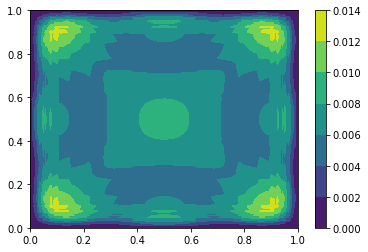

In [8]:
# Plot of absolute errors
abs_error = np.abs(down_sampled['Velocity[i] (m/s)'] - section_data['<u>'] * u_tau)
abs_error[abs_error > abs_error.std() * 4] = 0  # remove outliers
plt.tricontourf(section_data['y'], section_data['z'], abs_error)
plt.colorbar()

In [9]:
section_data['turbulent_ke'] = 0.5 * (section_data["<u'u'>"] + section_data["<v'v'>"] + section_data["<w'w'>"]) * u_tau**2

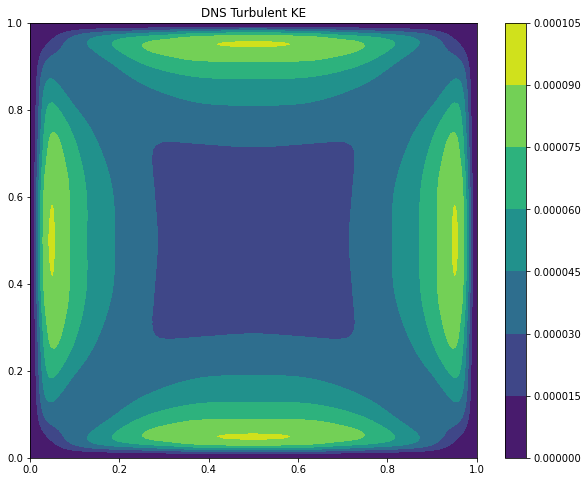

In [10]:
plt.figure(figsize=figsize)
plt.tricontourf(section_data['y'], section_data['z'], section_data['turbulent_ke'])
plt.title('DNS Turbulent KE')
plt.colorbar()

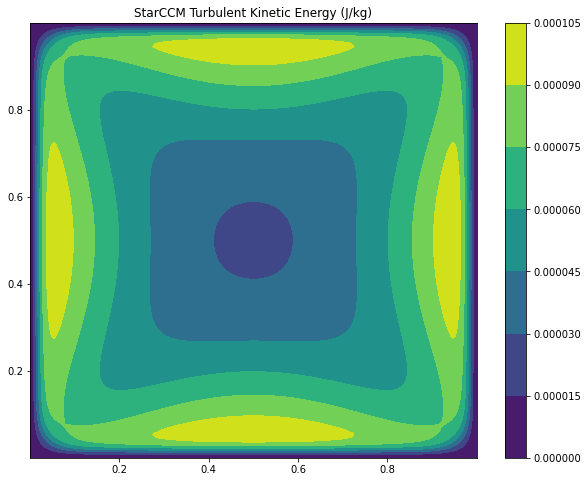

In [11]:
plt.figure(figsize=figsize)
plt.tricontourf(down_sampled['Y (m)'], down_sampled['Z (m)'], down_sampled['Turbulent Kinetic Energy (J/kg)'])
plt.title('StarCCM Turbulent Kinetic Energy (J/kg)')
plt.colorbar()

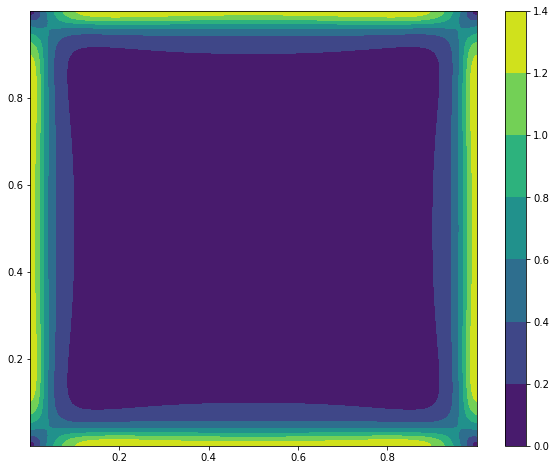

In [12]:
# Vorticity plot

plt.figure(figsize=figsize)
plt.tricontourf(down_sampled['Y (m)'], down_sampled['Z (m)'], down_sampled['Vorticity: Magnitude (/s)'])
plt.colorbar()

## Profiles

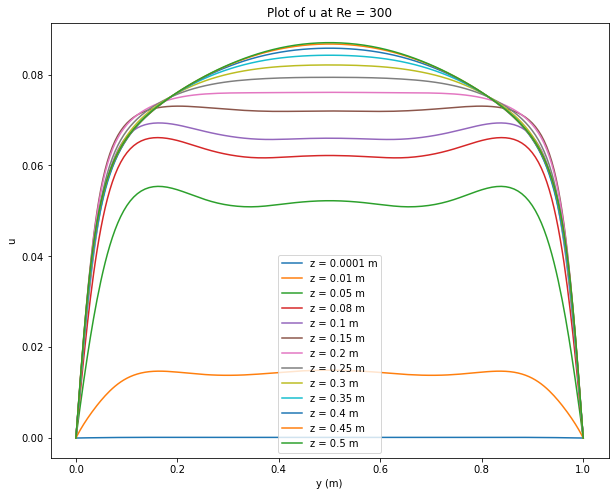

In [14]:
def read_profile_data(fpath):
    df = pd.read_csv(fpath, delimiter=' ', header=None)
    columns = df.iloc[0].dropna().values[1:]
    df = df.iloc[2:].dropna(axis=1)
    df.columns = columns
    df = df.astype(float)
    return df


for Re in Re_numbers:
    profile_dir = f'DuctFlow/profiles/Re{Re}/'
    profile_fpaths = [profile_dir + file_dir for file_dir in os.listdir(profile_dir)]
    profile_fpaths.sort()
    u_tau = Re * 1.48e-5

    plt.figure(figsize=figsize)
    for file in profile_fpaths:
        profile_data = read_profile_data(file)
        plt.plot(profile_data['y'].values, profile_data["<u>"].values * u_tau, label=f'z = {profile_data["z"].values[0]} m')

    plt.ylabel("u")
    plt.xlabel('y (m)')
    plt.title(f"Plot of u at Re = {Re}")
    plt.legend()
